In [1]:
pip install yfinance


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip3.7 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import yfinance as yf

In [6]:
# Inferior Goods
def pre_processing(tbl, name):
    return tbl.rename(columns = {'Close': 'Close_' + name})

hrl = pre_processing(yf.download("hrl"), "hrl")
wmt = pre_processing(yf.download("wmt"), "wmt")
dltr = pre_processing(yf.download("dltr"), "dltr")
cpb = pre_processing(yf.download("cpb"), "cpb")

data = hrl.merge(wmt, on = 'Date', how = 'inner').merge(dltr, on = 'Date', how = 'inner').merge(cpb, on = 'Date', how = 'inner')
data[['Close_hrl', 'Close_wmt', 'Close_dltr', 'Close_cpb']].corr()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/Users/mahittanikella/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Volume_x', 'Low_x', 'High_x', 'Adj Close_x', 'Open_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


,Close_hrl,Close_wmt,Close_dltr,Close_cpb
Close_hrl,1.000000,0.890296,0.960103,0.585353
Close_wmt,0.890296,1.000000,0.883791,0.354809
Close_dltr,0.960103,0.883791,1.000000,0.560949
Close_cpb,0.585353,0.354809,0.560949,1.000000


In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from scipy import stats

In [8]:
hrl = yf.download("hrl")
dltr = yf.download("dltr")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
data = hrl.merge(dltr, on = 'Date', how = 'inner')

In [10]:
data = data.rename(columns = {'Close_x': 'Close_hrl', 'Close_y': 'Close_dltr'})

In [11]:
data = data[data.index > pd.datetime(year = 2010, month = 12, day = 31)]

/Users/mahittanikella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [12]:
pairs = data[['Close_hrl', 'Close_dltr']]
pairs

,Close_hrl,Close_dltr
Date,,
2011-01-03,12.795000,28.275000
2011-01-04,12.670000,27.370001
2011-01-05,12.462500,26.040001
2011-01-06,12.442500,25.674999
2011-01-07,12.422500,25.905001
...,...,...
2022-12-01,47.590000,149.720001
2022-12-02,47.639999,151.199997
2022-12-05,47.189999,147.839996


In [14]:
from statsmodels.tsa.stattools import adfuller
HRL_ADF = adfuller(hrl)
print('P value for the Augmented Dickey-Fuller Test is', HRL_ADF[1])
DLTR_ADF = adfuller(dltr)
print('P value for the Augmented Dickey-Fuller Test is', DLTR_ADF[1])
Spread_ADF = adfuller(hrl - dltr)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(hrl / dltr)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])

P value for the Augmented Dickey-Fuller Test is 0.6189697249020946
P value for the Augmented Dickey-Fuller Test is 0.5856205702675028
P value for the Augmented Dickey-Fuller Test is 0.32261968207211944
P value for the Augmented Dickey-Fuller Test is 0.030799347217019657


Text(0.5, 1.0, 'Price Ratio between hrl and dltf')

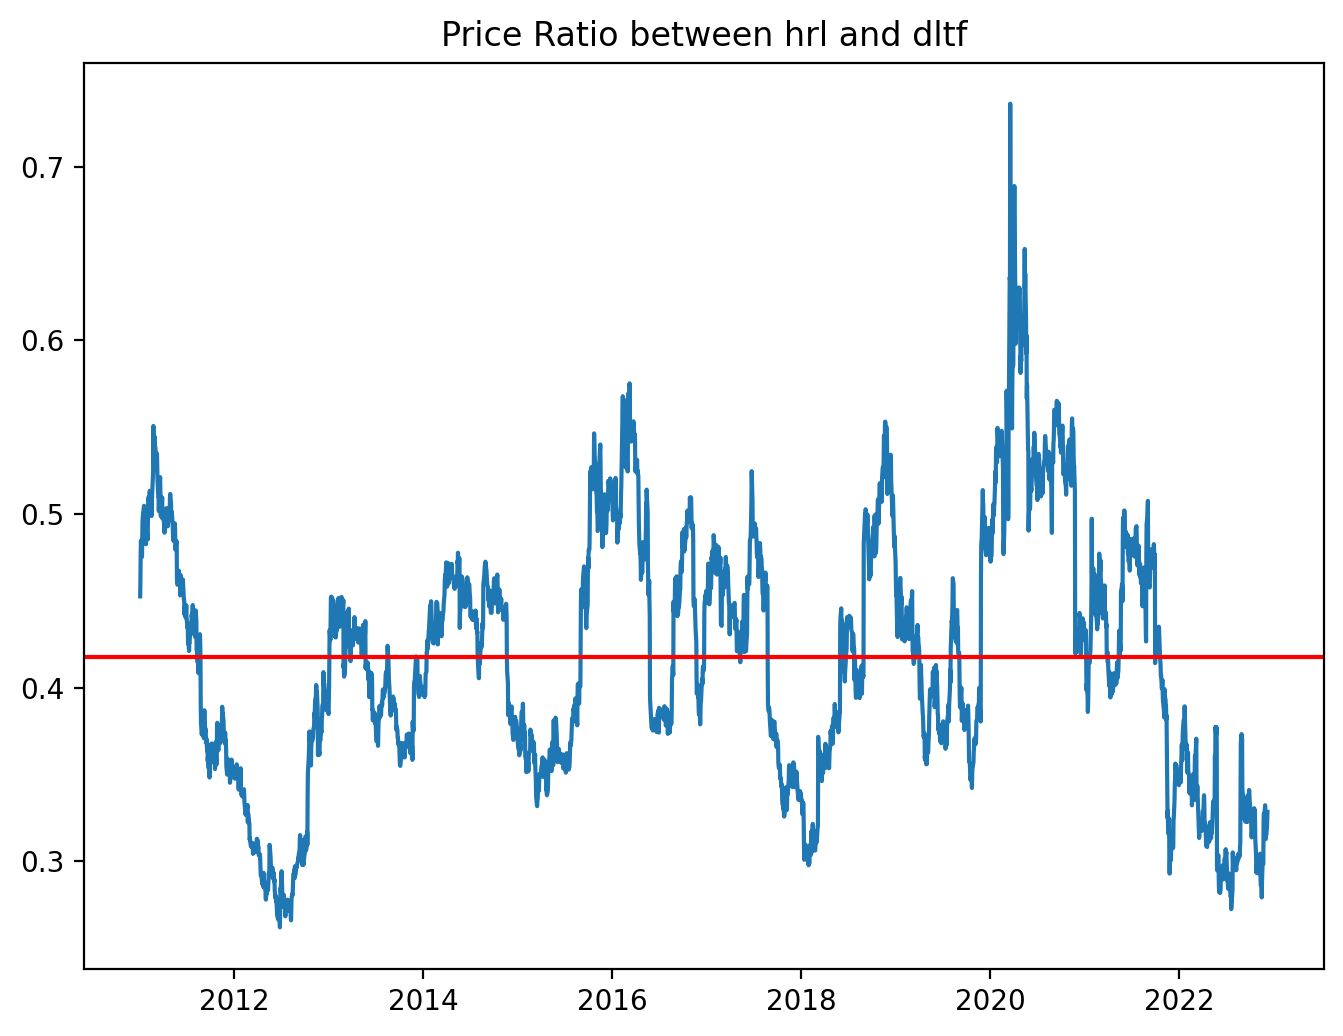

In [23]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=200)
ratio = hrl / dltr
plt.plot(ratio)
plt.axhline(ratio.mean(), color='red')
plt.title("Price Ratio between hrl and dltf")

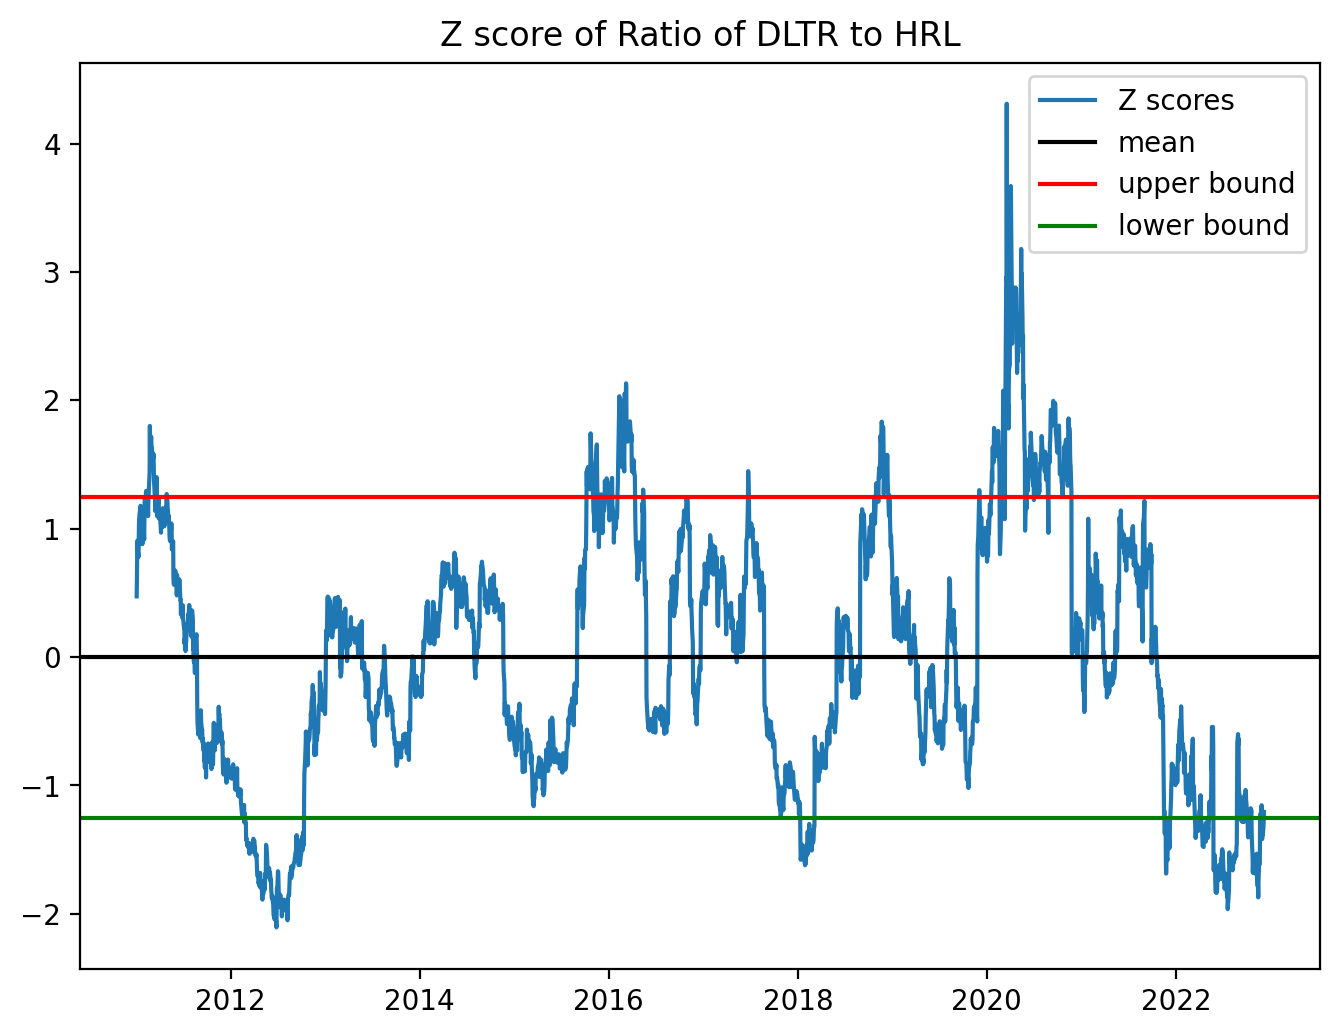

In [25]:
plt.figure(figsize=(8, 6), dpi=200)
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = 'Z scores')
plt.axhline(df_zscore.mean(), color = 'black', label = 'mean')
plt.axhline(1.25, color='red', label = 'upper bound') 
plt.axhline(-1.25, color='green', label = 'lower bound')
plt.title('Z score of Ratio of DLTR to HRL')
plt.legend()
plt.show()

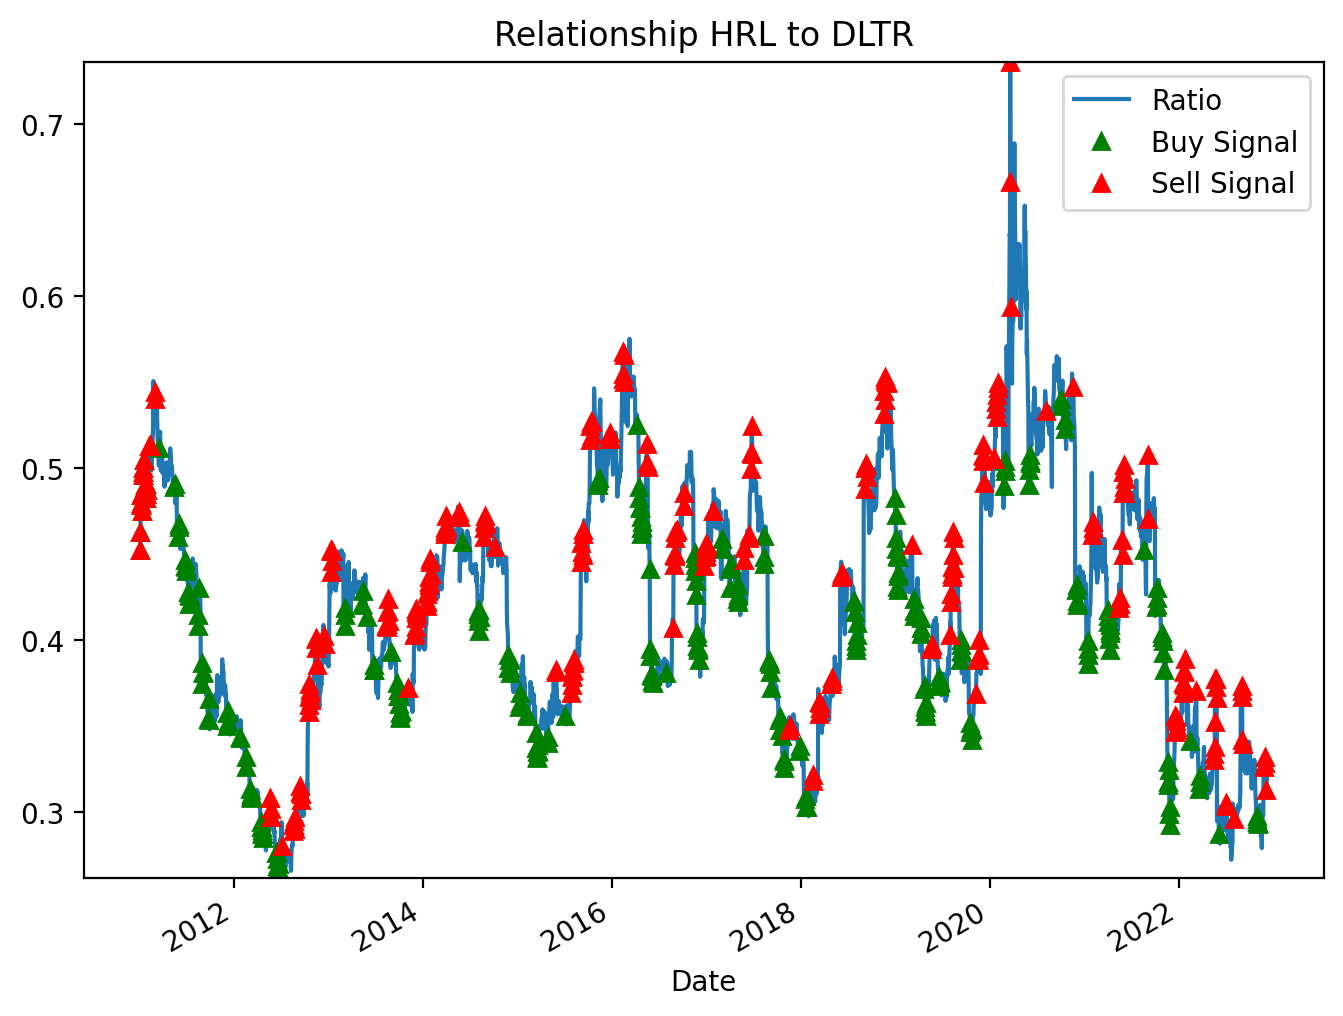

In [22]:
plt.figure(figsize=(8, 6), dpi=200)
ratio.plot()
mavg5 = ratio.rolling(window=5, center=False).mean()
mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (mavg5 - mavg20)/std_20
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1.25] = 0
sell[zscore_20_5<1.25] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship HRL to DLTR')
plt.show()

Holding end balance: 44248.0896581991
Our end balance: 62124.676100411365


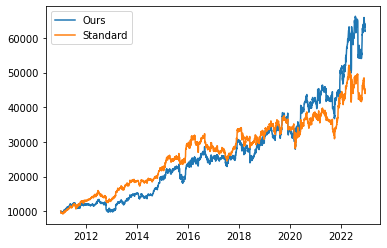

In [26]:
starting_balance = 10_000

initial_stock_a_quantity = starting_balance // 2 / hrl[0]
initial_stock_b_quantity = starting_balance // 2 / dltr[0]

stock_a_quantity =  initial_stock_a_quantity
stock_b_quantity = initial_stock_b_quantity

sell_percentage = 0.25

our_balances = []
typical_balances = []

for i in range(len(ratio)):
    if buy[i]:
        # buy stock a, sell stock b
        sell_b_quantity = stock_b_quantity * sell_percentage
        sell_b_balance = sell_b_quantity * dltr[i]
        stock_b_quantity -= sell_b_quantity
        
        buy_a_quantity = sell_b_balance / hrl[i]
        stock_a_quantity += buy_a_quantity
        
    elif sell[i]:
        # sell stock a, buy stock b
        sell_a_quantity = stock_a_quantity * sell_percentage
        sell_a_balance = sell_a_quantity * hrl[i]
        stock_a_quantity -= sell_a_quantity
        
        buy_b_quantity = sell_a_balance / dltr[i]
        stock_b_quantity += buy_b_quantity
        
    our_balances.append(hrl[i] * stock_a_quantity + dltr[i] * stock_b_quantity)
    typical_balances.append(hrl[i] * initial_stock_a_quantity + dltr[i] * initial_stock_b_quantity)

print("Holding end balance:", typical_balances[len(typical_balances) - 1])
print("Our end balance:", our_balances[len(our_balances) - 1])

plt.plot(data.index, our_balances, label="Ours")
plt.plot(data.index, typical_balances, label="Standard")
plt.legend()
plt.show()